# MNIST Auto Encoder

## Introduction

I'm doing this as a way to work up to a variational auto encoder. This tutorial
will be slightly more brief than previous ones. For details on some of the things
we do here, see `image_classifier_001.ipynb`. This covers *some* transforms. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import numpy as np
import matplotlib.pyplot as plt

## Loading and Preprocessing

There isn't much to do to prepare this data. We will just grab the test and
train datasets and normalize them. Worth noting, we won't need the targets,
but we don't need to do anything about that up front. 

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])
trainset = MNIST(
    root='./data/', train=True, 
    download=True, transform=transform
)
testset = MNIST(
    root='./data', train=False,
    download=True, transform=transform
)

We compute the mean and standard deviation to normalize this data. This is 
computed here so we learn the parameters of this distribution.

In [3]:
mu = trainset.data.float().mean() / 255
sigma = trainset.data.float().std() / 255

transform.transforms.append(
    transforms.Normalize(
        mean=(mu,), std=(sigma,)
    )
)

In [4]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(tensor(0.1307),), std=(tensor(0.3081),))
           )

Create a multithreaded data loader.

In [5]:
BATCH_SIZE = 64
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=2
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=2
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


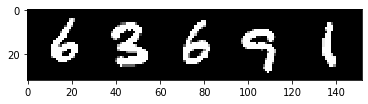

In [6]:
dataiter = iter(trainloader)
im, _ = dataiter.next()

SHOW_COUNT = 5
%matplotlib inline
def image_show(image):
    np_image = image.numpy()
    plt.imshow(np.transpose(np_image, (1, 2, 0)))
    plt.show()
    
image_show(
    torchvision.utils.make_grid(im[0:SHOW_COUNT, :, :, :])
)

## Network Topology

We are going to start with a simle feed forward network. As we get further
on, we will build a model with convolutions. 

In [7]:
# Most of the tutorials I've seen use the nn.Sequential 
# style for this. That's fine for this toy problem; however,
# it becomes limited as we move on to the VAE. 
class FFEncoder(nn.Module):
    def __init__(self,
                 input_dim=784,
                 intermediate_dim_1=128,
                 intermediate_dim_2=64,
                 latent_dim=32):
        super(FFEncoder, self).__init__()
        self.intermediate_1 = nn.Linear(input_dim, intermediate_dim_1)
        self.intermediate_2 = nn.Linear(intermediate_dim_1, intermediate_dim_2)
        self.latent = nn.Linear(intermediate_dim_2, latent_dim)

    def forward(self, x):
        x = F.relu(self.intermediate_1(x))
        x = F.relu(self.intermediate_2(x))
        x = self.latent(x)
        return x
        

class FFDecoder(nn.Module):
    def __init__(self,
                 input_dim=784,
                 intermediate_dim_1=128,
                 intermediate_dim_2=64,
                 latent_dim=32):
        super(FFDecoder, self).__init__()
        self.intermediate_2 = nn.Linear(latent_dim, intermediate_dim_2)
        self.intermediate_1 = nn.Linear(intermediate_dim_2, intermediate_dim_1)
        self.output = nn.Linear(intermediate_dim_1, input_dim)
        
    def forward(self, x):
        x = F.relu(self.intermediate_2(x))
        x = F.relu(self.intermediate_1(x))
        x = self.output(x)
        return x
        
        
class FeedForwardAutoEncoder(nn.Module):
    def __init__(self,
                 input_dim=784,
                 intermediate_dim_1=128,
                 intermediate_dim_2=64,
                 latent_dim=32):
        super(FeedForwardAutoEncoder, self).__init__()
        self.encoder = FFEncoder(
            input_dim, intermediate_dim_1, 
            intermediate_dim_2, latent_dim
        )
        self.decoder = FFDecoder(
            input_dim, intermediate_dim_1,
            intermediate_dim_2, latent_dim
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FeedForwardAutoEncoder().to(device)
print(model)

FeedForwardAutoEncoder(
  (encoder): FFEncoder(
    (intermediate_1): Linear(in_features=784, out_features=128, bias=True)
    (intermediate_2): Linear(in_features=128, out_features=64, bias=True)
    (latent): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): FFDecoder(
    (intermediate_2): Linear(in_features=32, out_features=64, bias=True)
    (intermediate_1): Linear(in_features=64, out_features=128, bias=True)
    (output): Linear(in_features=128, out_features=784, bias=True)
  )
)


In [9]:
LEARNING_RATE = 0.001
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [10]:
EPOCH_COUNT = 20
STEPS_BETWEEN_PRINT = 300

for epoch_index in range(EPOCH_COUNT):
    print(f'[Epoch {epoch_index + 1}]')
    running_loss = 0.0
    for batch_index, data in enumerate(trainloader, 0):
        # We are just moving the inputs. Would be wasteful to
        # move targets
        inputs = data[0].to(device)
        inputs = inputs.view(-1, 784)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_index % STEPS_BETWEEN_PRINT == STEPS_BETWEEN_PRINT - 1:
            print('\t[Batch {}] loss: {:3f}'.format(
                batch_index + 1,
                running_loss / STEPS_BETWEEN_PRINT
            ))
            running_loss = 0.0

[Epoch 1]
	[Batch 300] loss: 0.465992
	[Batch 600] loss: 0.280379
	[Batch 900] loss: 0.241278
[Epoch 2]
	[Batch 300] loss: 0.214224
	[Batch 600] loss: 0.199321
	[Batch 900] loss: 0.189081
[Epoch 3]
	[Batch 300] loss: 0.178890
	[Batch 600] loss: 0.174477
	[Batch 900] loss: 0.168874
[Epoch 4]
	[Batch 300] loss: 0.165505
	[Batch 600] loss: 0.162153
	[Batch 900] loss: 0.159115
[Epoch 5]
	[Batch 300] loss: 0.156796
	[Batch 600] loss: 0.155604
	[Batch 900] loss: 0.154193
[Epoch 6]
	[Batch 300] loss: 0.152420
	[Batch 600] loss: 0.150149
	[Batch 900] loss: 0.149441
[Epoch 7]
	[Batch 300] loss: 0.147356
	[Batch 600] loss: 0.146270
	[Batch 900] loss: 0.145658
[Epoch 8]
	[Batch 300] loss: 0.144169
	[Batch 600] loss: 0.143261
	[Batch 900] loss: 0.142762
[Epoch 9]
	[Batch 300] loss: 0.142031
	[Batch 600] loss: 0.141275
	[Batch 900] loss: 0.140448
[Epoch 10]
	[Batch 300] loss: 0.139587
	[Batch 600] loss: 0.139754
	[Batch 900] loss: 0.139231
[Epoch 11]
	[Batch 300] loss: 0.138950
	[Batch 600] loss: 0

## Test

We can write a simple bit of code to test the train and validation data. 
It's easy to see that we overfit the data slightly. There are a few 
solutions to this. One is to use rotations. Because I haven't done 
this before, I'm going to try it and see what we get. The others are
to train for less time or use dropout.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 784])


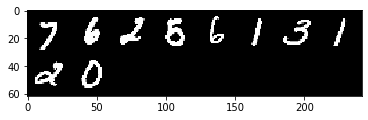

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


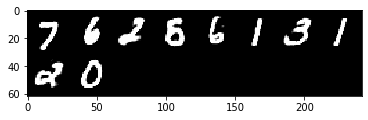

In [11]:
dataiter = iter(trainloader)
im, _ = dataiter.next()

model.eval()
with torch.no_grad():
    data = im.to(device)
    output = model(data.view(-1, 784))
    print(output.size())

SHOW_COUNT = 10
%matplotlib inline
def image_show(image):
    np_image = image.numpy()
    plt.imshow(np.transpose(np_image, (1, 2, 0)))
    plt.show()
    
image_show(
    torchvision.utils.make_grid(im[0:SHOW_COUNT, :, :, :])
)
reshape_output = output.cpu().reshape(BATCH_SIZE, 1, 28, 28)
image_show(
    torchvision.utils.make_grid(reshape_output[0:SHOW_COUNT, :, :, :])
)